# Fit global epistasis models to functional scores for each selection to get mutation functional effects

Import Python modules.
We use `multidms` for the fitting:

In [1]:
import alignparse.utils

import altair as alt

import dms_variants.codonvarianttable

import matplotlib.pyplot as plt

import multidms

import pandas as pd

This notebook is parameterized by `papermill`.
The next cell is tagged as `parameters` to get the passed parameters.

In [2]:
# this cell is tagged parameters for `papermill` parameterization
selection = None
func_scores = None
func_effects = None
site_numbering_map = None
global_epistasis_params = None
threads = None

In [3]:
# Parameters
global_epistasis_params = {
    "clip_lower": "median_stop",
    "clip_upper": None,
    "collapse_identical_variants": False,
    "latent_effects_regularization": "1e-07",
}
selection = "Lib1-250605-high_ACE2_2"
func_scores = "results/func_scores/Lib1-250605-high_ACE2_2_func_scores.csv"
func_effects = (
    "results/func_effects/by_selection/Lib1-250605-high_ACE2_2_func_effects.csv"
)
site_numbering_map = "data/site_numbering_map.csv"
threads = 1


Read and clip functional scores:

In [4]:
func_scores_df = (
    pd.read_csv(func_scores, na_filter=None)
    .assign(condition=selection)
    .pipe(dms_variants.codonvarianttable.CodonVariantTable.classifyVariants)
)

median_stop = func_scores_df.query("variant_class == 'stop'")["func_score"].median()

for bound in ["upper", "lower"]:
    clip = global_epistasis_params[f"clip_{bound}"]
    if clip is None:
        print(f"No clipping on {bound} bound of functional scores")
    else:
        if clip == "median_stop":
            if pd.isnull(median_stop):
                raise ValueError(f"{median_stop=}")
            clip = median_stop
        assert isinstance(clip, (int, float)), clip
        print(f"Clipping {bound} bound of functional scores to {clip}")
        func_scores_df["func_score"] = func_scores_df["func_score"].clip(
            **{bound: clip}
        )

No clipping on upper bound of functional scores
Clipping lower bound of functional scores to -8.3125


Renumber to sequential sites to allow arbitrary strings as sites:

In [5]:
site_numbering = pd.read_csv(site_numbering_map)
assert len(site_numbering) == site_numbering["sequential_site"].nunique()
assert len(site_numbering) == site_numbering["reference_site"].nunique()

renumber_to_sequential = alignparse.utils.MutationRenumber(
    number_mapping=site_numbering,
    old_num_col="reference_site",
    new_num_col="sequential_site",
    wt_nt_col=None,
    allow_arbitrary_numbers=True,
)

renumber_to_reference = alignparse.utils.MutationRenumber(
    number_mapping=site_numbering,
    old_num_col="sequential_site",
    new_num_col="reference_site",
    wt_nt_col=None,
    allow_arbitrary_numbers=True,
)

func_scores_df_sequential = func_scores_df.assign(
    aa_substitutions=lambda x: x["aa_substitutions"].apply(
        renumber_to_sequential.renumber_muts,
        allow_gaps=True,
        allow_stop=True,
    )
)

Initialize the data for `multidms`:

In [6]:
data = multidms.Data(
    variants_df=func_scores_df_sequential,
    reference=selection,
    alphabet=multidms.AAS_WITHSTOP_WITHGAP,
    collapse_identical_variants=global_epistasis_params["collapse_identical_variants"],
    verbose=False,
    nb_workers=threads,
    assert_site_integrity=True,
)

Now initialize the `multidms` model and fit it:

In [7]:
latent_effects_regularization = float(
    global_epistasis_params["latent_effects_regularization"]
)
print(f"{latent_effects_regularization=}")

fit_kwargs = {"maxiter": 5000, "tol": 1e-7}
if "fit_kwargs" in global_epistasis_params:
    fit_kwargs.update(global_epistasis_params["fit_kwargs"])
    # added to deal w problems in YAML serialization of scientific notation
    if "tol" in fit_kwargs:
        fit_kwargs["tol"] = float(fit_kwargs["tol"])
print(f"{fit_kwargs=}")

# initialize with default params, which give sigmoid global epistasis function
model = multidms.Model(data)

model.fit(scale_coeff_ridge_beta=latent_effects_regularization, **fit_kwargs)

latent_effects_regularization=1e-07
fit_kwargs={'maxiter': 5000, 'tol': 1e-07}


Look at accuracy of predictions and the global epistasis fit:

/home/sooriyakks/miniconda3/envs/dms-vep-pipeline-3/lib/python3.12/site-packages/multidms/model.py:1061: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.


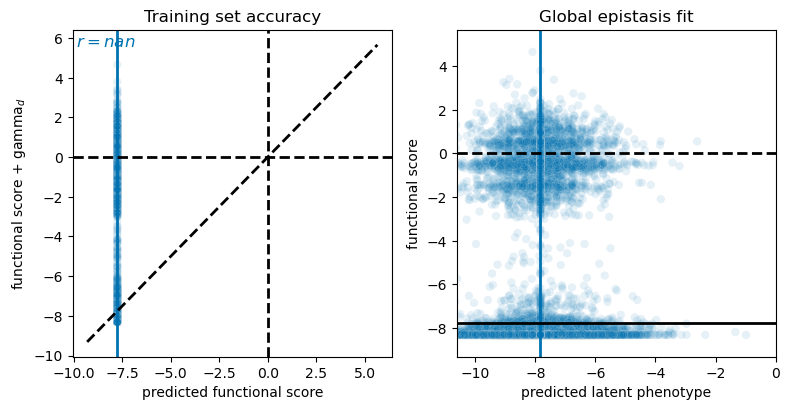

In [8]:
fig, ax = plt.subplots(1, 2, figsize=[8, 4])
model.plot_epistasis(ax=ax[1], alpha=0.1, show=False, legend=False)
model.plot_pred_accuracy(ax=ax[0], alpha=0.1, show=False, legend=False)
ax[1].set_title("Global epistasis fit")
ax[0].set_title("Training set accuracy")
plt.show()

Plot the distribution of latent phenotype functional scores with a few different cutoffs on `times_seen` (the number of variants in which a mutaiton is seen):

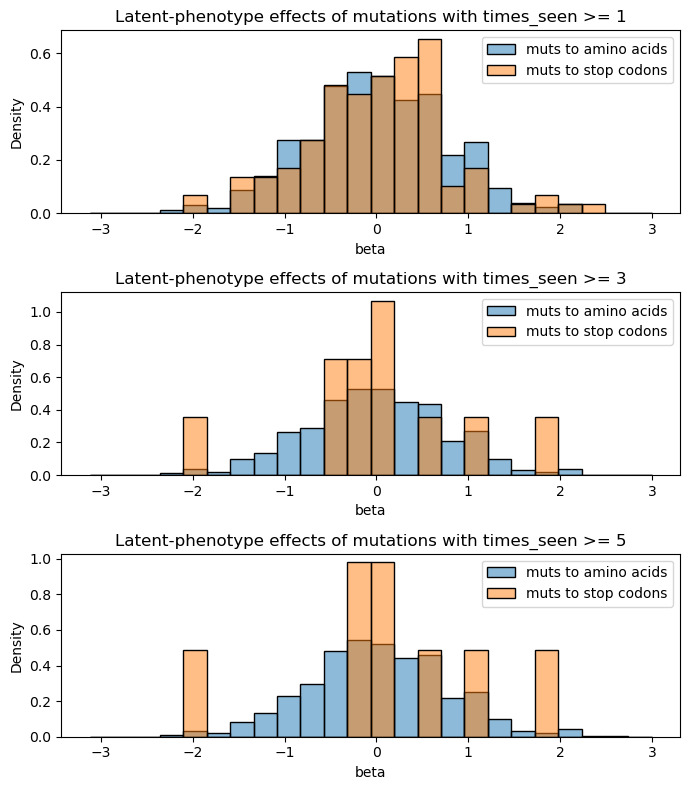

In [9]:
fig, axes = plt.subplots(3, 1, figsize=[7, 8])
for times_seen, ax in zip([1, 3, 5], axes):
    model.plot_param_hist("beta", ax=ax, show=False, times_seen_threshold=times_seen)
    ax.legend()
    ax.set_title(
        f"Latent-phenotype effects of mutations with times_seen >= {times_seen}"
    )
plt.tight_layout()
plt.show()

Get the effect of each mutation on the latent phenotype observed phenotype of the functional score (which we simply call the "functional effect" of the mutation):

In [10]:
mut_effects = (
    pd.concat(
        [
            # get mutant effects
            (
                model.get_mutations_df(phenotype_as_effect=True).rename(
                    columns={
                        f"times_seen_{selection}": "times_seen",
                        "wts": "wildtype",
                        "sites": "site",
                        "muts": "mutant",
                        f"predicted_func_score_{selection}": "functional_effect",
                        "beta": "latent_phenotype_effect",
                    }
                )
            ),
            # add wildtypes, which all have effects of 0
            pd.DataFrame(
                {
                    "site": data.site_map.index,
                    "wildtype": data.site_map[selection],
                    "mutant": data.site_map[selection],
                    "latent_phenotype_effect": 0,
                    "functional_effect": 0,
                }
            ),
        ],
    )
    .sort_values(["site", "mutant"])
    # convert back to reference numbering
    .assign(
        site=lambda x: x["site"].map(
            site_numbering.set_index("sequential_site")["reference_site"].to_dict()
        )
    )
    .reset_index(drop=True)
)

mut_effects

,latent_phenotype_effect,functional_effect,times_seen,wildtype,site,mutant
0,1.164404,0.0,2.0,M,1,I
1,0.000000,0.0,NaN,M,1,M
2,1.517956,0.0,1.0,M,1,T
3,-0.306939,0.0,3.0,F,2,C
4,0.000000,0.0,NaN,F,2,F
...,...,...,...,...,...,...
8350,-1.813270,0.0,6.0,S,1252,T
8351,1.085522,0.0,10.0,S,1252,Y
8352,0.000000,0.0,NaN,*,1253,*
8353,0.885279,0.0,1.0,*,1253,L


Look at correlation between mutation effects estimated from global epistasis model and the average of the functional scores for the single mutants (after applying any clipping).
Ideally, this correlation should be good, especially for mutations with multiple single-mutant variants:

In [11]:
single_muts = (
    func_scores_df.query("n_aa_substitutions == 1")
    .groupby("aa_substitutions", as_index=False)
    .aggregate(
        func_score=pd.NamedAgg("func_score", "mean"),
        n_variants=pd.NamedAgg("barcode", "count"),
    )
    .rename(columns={"aa_substitutions": "mutation"})
    .merge(
        (
            mut_effects.assign(
                mutation=lambda x: x["wildtype"] + x["site"].astype(str) + x["mutant"]
            ).rename(columns={"functional_effect": "mut_effect"})[
                ["mutation", "mut_effect"]
            ]
        ),
        on="mutation",
        how="inner",
        validate="one_to_one",
    )
)

mutation_selection = alt.selection_point(
    on="mouseover",
    empty=False,
    fields=["mutation"],
)

min_n_variants = alt.param(
    value=1,
    bind=alt.binding_range(
        name="only show mutations with >= this many single-mutant variants",
        min=1,
        max=min(5, single_muts["n_variants"].max()),
        step=1,
    ),
)

single_muts_scatter = (
    alt.Chart(single_muts)
    .transform_filter(alt.datum["n_variants"] >= min_n_variants)
    .add_params(mutation_selection, min_n_variants)
    .encode(
        alt.X(
            "func_score",
            title="average functional score of single-mutant variants",
            scale=alt.Scale(nice=False, padding=10),
        ),
        alt.Y(
            "mut_effect",
            title="mutation effect from global epistasis model",
            scale=alt.Scale(nice=False, padding=10),
        ),
        strokeWidth=alt.condition(mutation_selection, alt.value(2), alt.value(0)),
        size=alt.condition(mutation_selection, alt.value(60), alt.value(35)),
        tooltip=[
            "mutation",
            "n_variants",
            alt.Tooltip("func_score", format=".2f"),
            alt.Tooltip("mut_effect", format=".2f"),
        ],
    )
    .mark_circle(fill="black", fillOpacity=0.2, stroke="red")
    .properties(width=250, height=250)
)

single_muts_r = (
    single_muts_scatter.transform_regression("func_score", "mut_effect", params=True)
    .transform_calculate(
        r=alt.expr.if_(
            alt.datum["coef"][1] >= 0,
            alt.expr.sqrt(alt.datum["rSquared"]),
            -alt.expr.sqrt(alt.datum["rSquared"]),
        ),
        label='"r = " + format(datum.r, ".2f")',
    )
    .mark_text(align="left", color="purple", fontWeight=500, opacity=1)
    .encode(
        x=alt.value(3), y=alt.value(10), text=alt.Text("label:N"), size=alt.value(15)
    )
)

single_muts_chart = (single_muts_scatter + single_muts_r).configure_axis(grid=False)

single_muts_chart

alt.LayerChart(...)

Write the mutational effects to a file:

In [12]:
print(f"Writing the mutational effects to {func_effects}")

mut_effects.to_csv(func_effects, index=False, float_format="%.4g")

Writing the mutational effects to results/func_effects/by_selection/Lib1-250605-high_ACE2_2_func_effects.csv
